# Importing Libraries and Defining data

In [2]:
import tensorflow as tf
from tensorflow import keras

#Importing tensorflow libs
from keras.preprocessing.image import ImageDataGenerator #image generator label data based on the dir the image in contained in
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.utils import get_file, image_dataset_from_directory

#Confusion Matrix Libs
from sklearn.metrics import confusion_matrix
import itertools

#Importing general libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pathlib
import os
import random
import shutil

### Declaring global variables

In [3]:
batch_size = 128
epochs = 15
IMG_HEIGHT = 128
IMG_WIDTH = 128
train_dir = 'datasets/chest_xray/chest_xray/train/'
val_dir = 'datasets/chest_xray/chest_xray/val/'
test_dir = 'datasets/chest_xray/chest_xray/test/'

### Creating folder for Validation images

In [4]:
# Creating Val folder
#os.chdir('datasets/chest_xray/chest_xray/')
#if os.path.isdir('val/NORMAL') is False:
#   os.makedirs('val/NORMAL')
#   os.makedirs('val/PNEUMONIA')

# Moving Images from train folder to val folder
source = 'datasets/chest_xray/chest_xray/train/PNEUMONIA/'
dest = 'datasets/chest_xray/chest_xray/val/PNEUMONIA'
files = os.listdir(source)
np_of_files = len(files) // 25
for file_name in random.sample(files, np_of_files):
        shutil.move(os.path.join(source, file_name), dest)

# Moving Normal Images from train folder to val folder
source = 'datasets/chest_xray/chest_xray/train/NORMAL/'
dest = 'datasets/chest_xray/chest_xray/val/NORMAL'
files = os.listdir(source)
np_of_files = len(files) // 25
for file_name in random.sample(files, np_of_files):
        shutil.move(os.path.join(source, file_name), dest)

### Setting up plotImages

In [5]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, 5, figsize=(len(images_arr),len(images_arr)))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% normal")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% pnuemonia")
    plt.show()

### Setting up Confusion Matrix

In [6]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Preprocessing and Augmentation

In [7]:
train_image_generator = ImageDataGenerator(rescale=1/255)
val_image_generator = ImageDataGenerator(rescale=1/255)

train_datagen = train_image_generator.flow_from_directory(
                                                        train_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='grayscale',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= True,
                                                        seed= 42
    )

val_datagen = val_image_generator.flow_from_directory(
                                                        val_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='grayscale',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= True,
                                                        seed= 42
    )

Found 4061 images belonging to 2 classes.
Found 913 images belonging to 2 classes.


[1. 1. 1. 0. 1.]


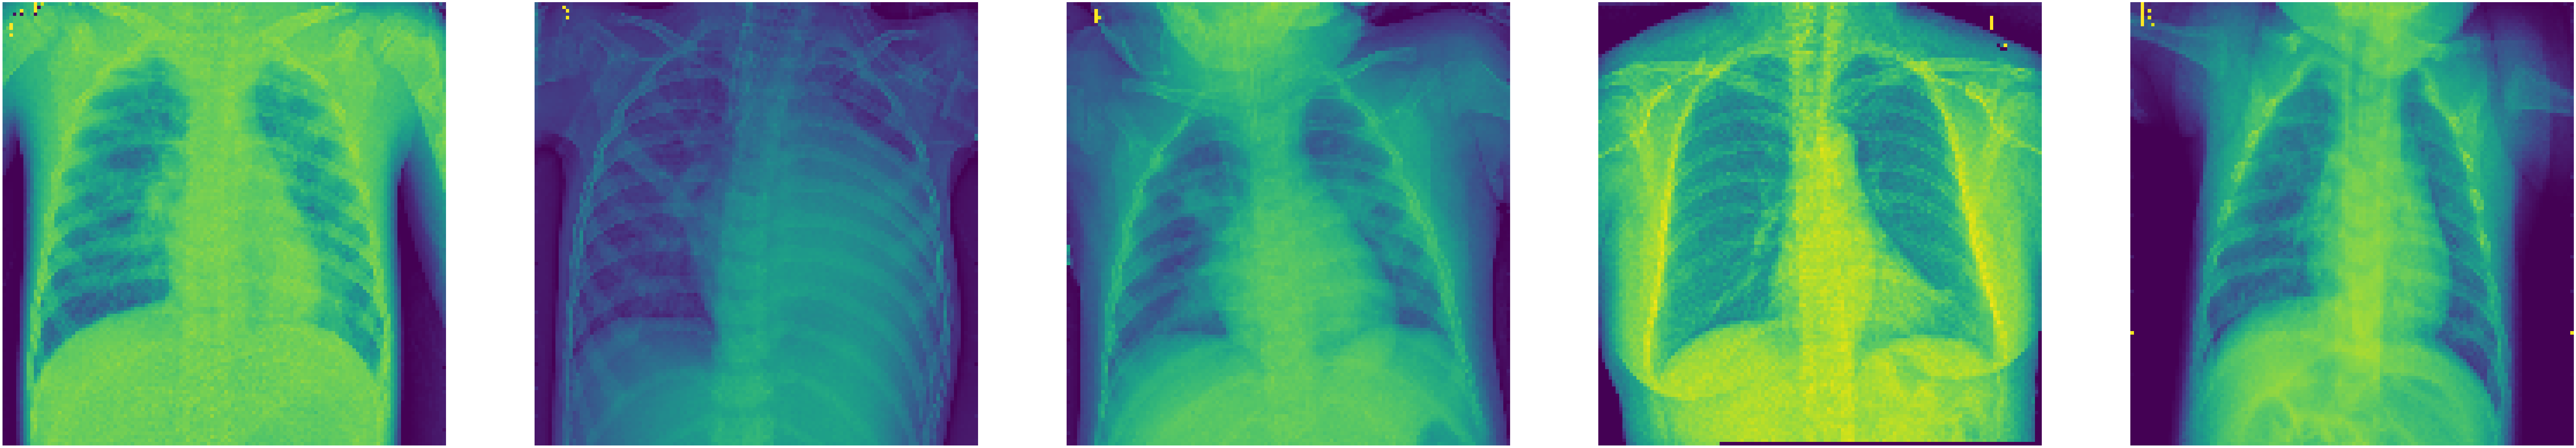

In [8]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

In [9]:
train_image_generator = ImageDataGenerator(
    rotation_range= 0.5,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    rescale= 1./255
)

train_datagen = train_image_generator.flow_from_directory(
    train_dir,
    target_size= (IMG_HEIGHT,IMG_WIDTH),
    color_mode='grayscale',
    batch_size= batch_size,
    class_mode= 'binary',
    classes=['NORMAL','PNEUMONIA'],
    shuffle= True,
    seed= 42
    )


Found 4061 images belonging to 2 classes.


[1. 1. 1. 0. 1.]


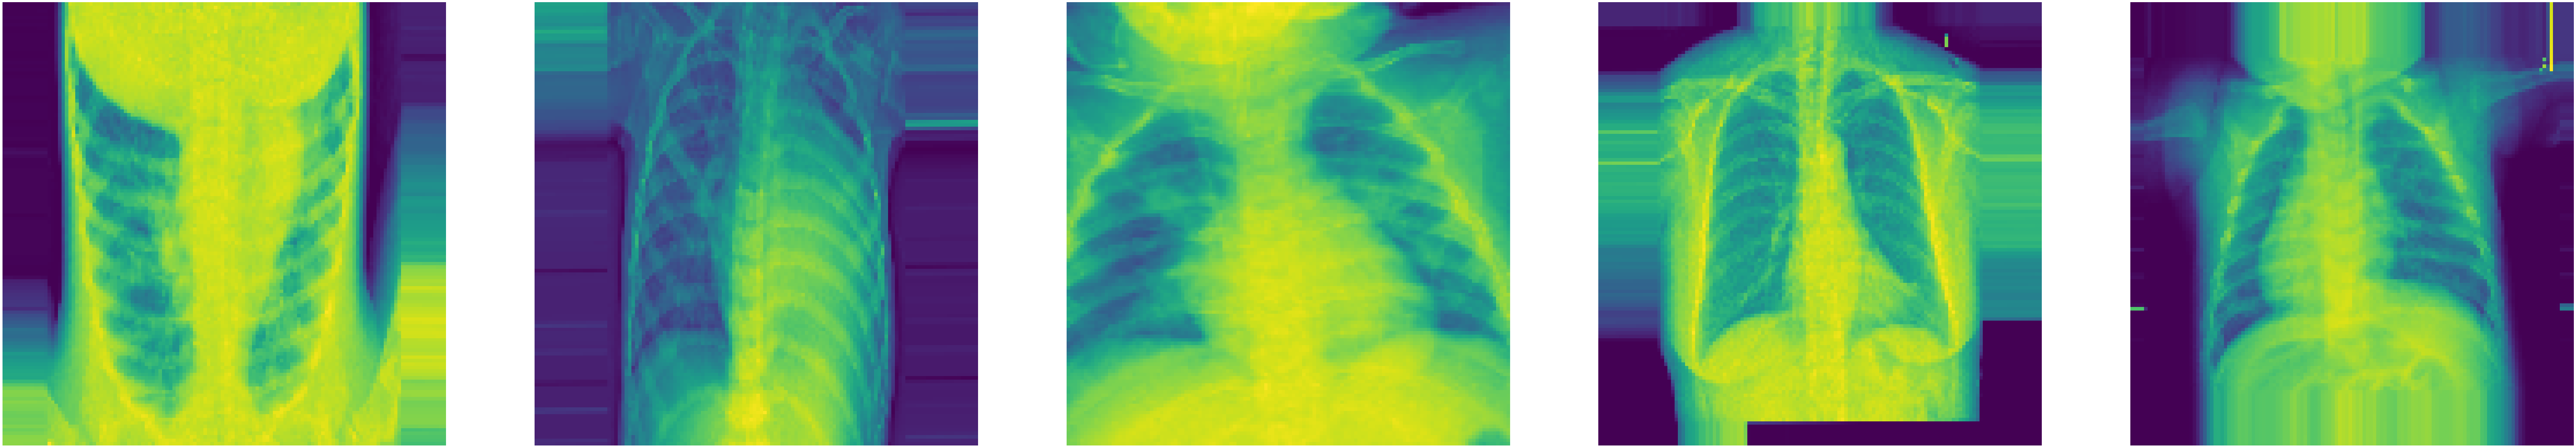

In [10]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

# Setting up the CNN

In [11]:
model = Sequential([
        Conv2D(filters=32, 
                 kernel_size=3, 
                 strides=1,
                 padding='SAME',
                 activation='relu', 
                 input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)
                 ),
        MaxPooling2D(pool_size=2, strides=2),

        Conv2D(filters=64, 
                 kernel_size=3,
                 strides=1, 
                 #padding='SAME',
                 activation='relu', 
                 ),
        MaxPooling2D(pool_size=2, strides=2),
        
        Conv2D(filters=128, 
                 kernel_size=5,
                 strides=1, 
                 #padding='SAME',
                 activation='relu', 
                 ),
        MaxPooling2D(pool_size=2, strides=2),

        Conv2D(filters=256, 
                 kernel_size=7,
                 strides=1, 
                 #padding='SAME',
                 activation='relu', 
                 ),
        MaxPooling2D(pool_size=2, strides=2),

        Flatten(),
        Dropout(0.4),
        Dense(256,activation = 'relu'),
        Dense(2, activation = 'softmax')
])



Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-12 17:24:18.916763: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-12 17:24:18.917414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 128)      0

# Fitting Model

In [14]:
history = model.fit(
    train_datagen,
    steps_per_epoch = train_datagen.n//train_datagen.batch_size,
    epochs = epochs,
    validation_data= val_datagen,
    validation_steps= val_datagen.n//val_datagen.batch_size,
    verbose = 2
)

Epoch 1/15


2022-07-12 17:24:20.722590: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-12 17:24:21.203087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-12 17:25:05.077093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 - 51s - loss: 0.6042 - accuracy: 0.7218 - val_loss: 0.5655 - val_accuracy: 0.7467 - 51s/epoch - 2s/step
Epoch 2/15
31/31 - 46s - loss: 0.5351 - accuracy: 0.7485 - val_loss: 0.5691 - val_accuracy: 0.7455 - 46s/epoch - 1s/step
Epoch 3/15
31/31 - 44s - loss: 0.4886 - accuracy: 0.7729 - val_loss: 0.5755 - val_accuracy: 0.6373 - 44s/epoch - 1s/step
Epoch 4/15
31/31 - 44s - loss: 0.4106 - accuracy: 0.8091 - val_loss: 0.3384 - val_accuracy: 0.8661 - 44s/epoch - 1s/step
Epoch 5/15
31/31 - 41s - loss: 0.3738 - accuracy: 0.8416 - val_loss: 0.2999 - val_accuracy: 0.8761 - 41s/epoch - 1s/step
Epoch 6/15
31/31 - 42s - loss: 0.3386 - accuracy: 0.8495 - val_loss: 0.3063 - val_accuracy: 0.8817 - 42s/epoch - 1s/step
Epoch 7/15
31/31 - 42s - loss: 0.3345 - accuracy: 0.8530 - val_loss: 0.2773 - val_accuracy: 0.8750 - 42s/epoch - 1s/step
Epoch 8/15
31/31 - 42s - loss: 0.2980 - accuracy: 0.8774 - val_loss: 0.2146 - val_accuracy: 0.9063 - 42s/epoch - 1s/step
Epoch 9/15
31/31 - 41s - loss: 0.3121 - acc

### Visualizing training results

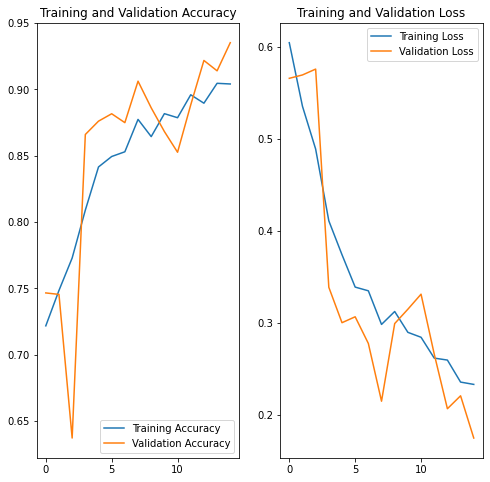

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predicting the Data

In [16]:
test_image_generator = ImageDataGenerator(rescale = 1./255)
test_datagen = test_image_generator.flow_from_directory(
                                                        directory= 'datasets/chest_xray/chest_xray/test/',
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='grayscale',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        shuffle= False,
                                                        seed= 42
    )

Found 624 images belonging to 2 classes.


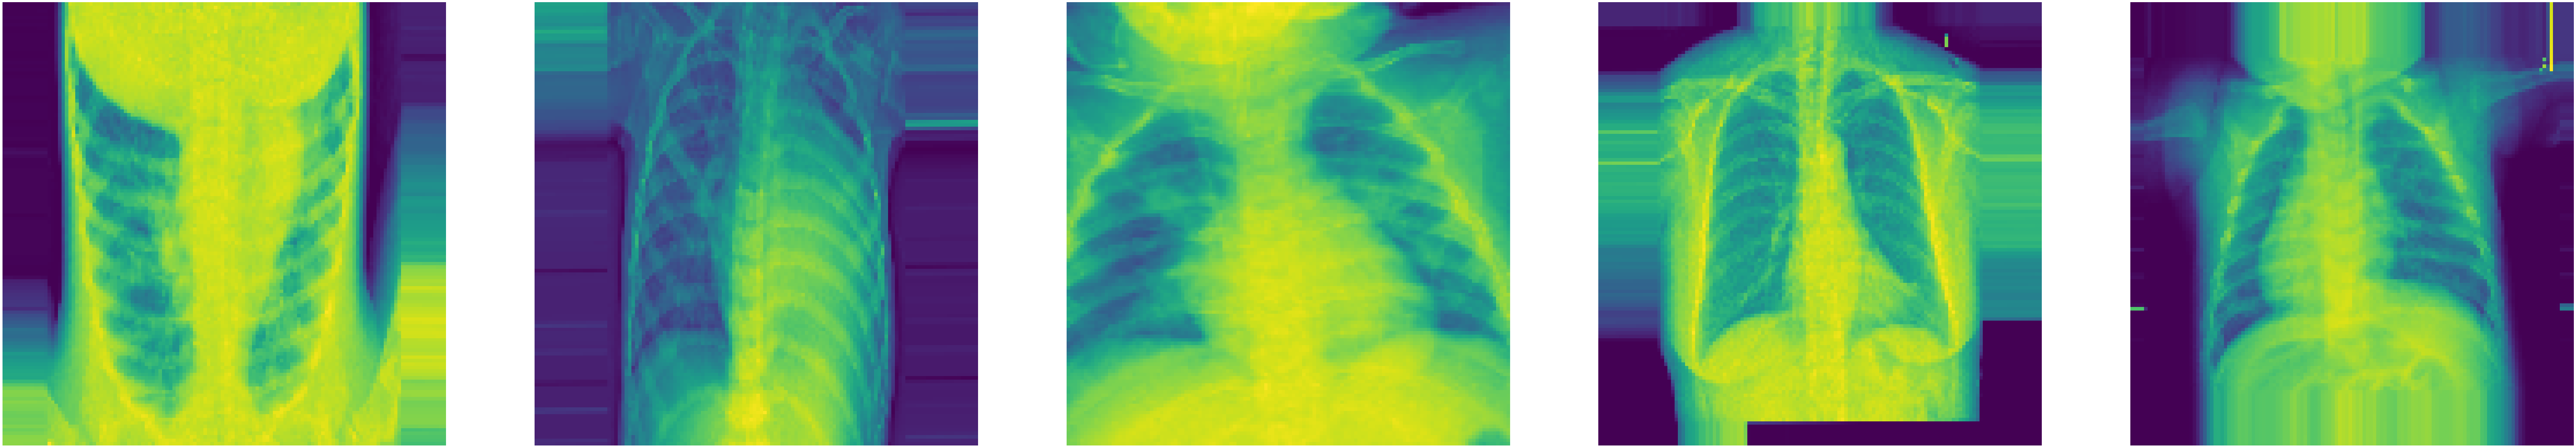

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


In [17]:
img, labels = next(test_datagen)
plotImages(imgs)
print(labels)

### Predicting the Model

In [18]:
predictions = model.predict(
                            x=test_datagen, 
                            batch_size= batch_size,
                            verbose=0
    )

2022-07-12 17:34:49.716239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# Visualize testing result

Confusion matrix, without normalization
[[165  69]
 [  9 381]]


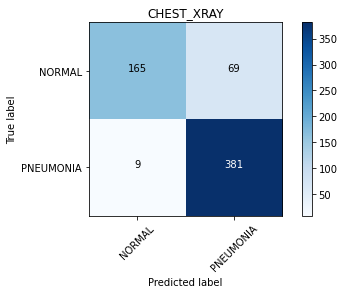

In [19]:
cm = confusion_matrix(y_true=test_datagen.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='CHEST_XRAY')